# Some regularizations and optimization algorithms on [Fruits 360 dataset](https://github.com/Horea94/Fruit-Images-Dataset)
By [Zahra Taheri](https://github.com/zata213), November 27, 2020

In [1]:
#!pip install -q kaggle

!pip install -q git+https://github.com/Kaggle/kaggle-api.git --upgrade

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahrataheri","key":"5c435c8d31e9c4c62327ef5ac8f60102"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51            827         60  1.0              
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            322         21  0.9411765        
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           1359         49  1.0              
imoore/2020-us-general-election-turnout-rates                2020 US General Election Turnout rates 

**Download the dataset from kaggle:**
Click the three dots next to "New notebook" button on the dataset page. Click "Copy API command" and simply paste that in your colab notebook and run it.


In [6]:
!kaggle datasets download -d moltean/fruits

 97% 737M/760M [00:06<00:00, 99.7MB/s]
100% 760M/760M [00:06<00:00, 122MB/s] 


### Import libraries

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
#from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary

## Loading Fruit-360

In [8]:
if os.path.exists("/content/fruits-360/")==False:
  print("unzip files!")
  !unzip -q fruits.zip

unzip files!


In [9]:
#Define path to the directory
 
data_directory="/content/fruits-360/"
print('Data directory: ', os.listdir(data_directory))

os.chdir(data_directory)
 
print(os.getcwd())

Data directory:  ['Training', 'readme.md', 'test-multiple_fruits', 'LICENSE', 'Test', 'papers']
/content/fruits-360


## Preparation of the dataset

In [10]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    #transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset1 = ImageFolder(data_directory + '/Training', transform=transforms.ToTensor())
train_dataset = ImageFolder(data_directory + '/Training', transform=train_transforms)
test_dataset = ImageFolder(data_directory + '/Test', transform=test_transforms)
print(len(train_dataset))
print(len(test_dataset))

67692
22688


In [11]:
print(train_dataset.classes)
len(train_dataset.classes)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

131

In [12]:
train_dataset[7000][0].shape

torch.Size([3, 100, 100])

In [13]:
# Split 10% of the training set as validation set

torch.manual_seed(42)
valid_size = (len(train_dataset)*10)//100
train_size = len(train_dataset) - valid_size

train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
len(train_data), len(valid_data)

(60923, 6769)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Building Convolutional Neural Network with PyTorch

In [15]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size,  shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

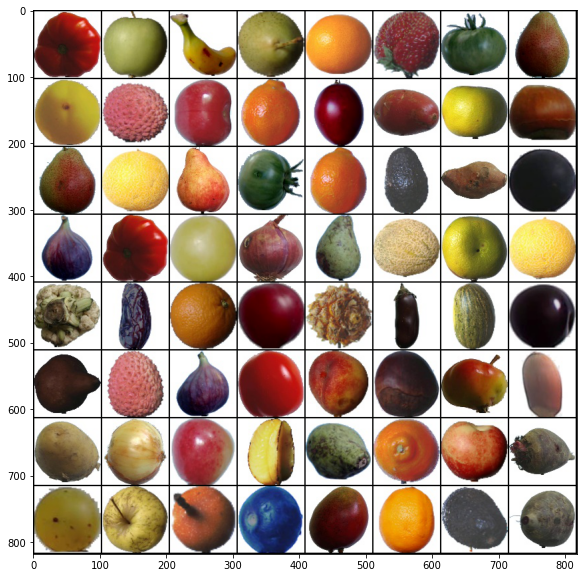

In [16]:
from torchvision.utils import make_grid

train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
for images, labels in train_loader1:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=2, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(3200, 131) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)     
        out = self.dropout1(out)     

        # Flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [24]:
model = CNNModel()
model.to(device)

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (cnn3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=131, bias=True)
)

In [25]:
summary(model, (3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 103, 103]             208
              ReLU-2         [-1, 16, 103, 103]               0
         MaxPool2d-3           [-1, 16, 51, 51]               0
            Conv2d-4           [-1, 32, 50, 50]           2,080
              ReLU-5           [-1, 32, 50, 50]               0
         MaxPool2d-6           [-1, 32, 25, 25]               0
            Conv2d-7           [-1, 64, 24, 24]           8,256
              ReLU-8           [-1, 64, 24, 24]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10          [-1, 128, 11, 11]          32,896
             ReLU-11          [-1, 128, 11, 11]               0
        MaxPool2d-12            [-1, 128, 5, 5]               0
          Dropout-13            [-1, 128, 5, 5]               0
           Linear-14                  [

In [26]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


batch_size = 64
n_iters = 6000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

6


In [27]:
def correct_f(outputs, labels):
      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, dim=1)
      correct = torch.sum(predicted == labels).item()
      return  correct

In [28]:
'''
Train the model
'''
iter = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
               
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
            accuracy = torch.tensor(100 * correct // total)
            
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Validation Accuracy: {}'.format(iter, loss.data, accuracy))

Iteration: 500. Training Loss: 0.24452020227909088. Validation Accuracy: 89
Iteration: 1000. Training Loss: 0.1332636922597885. Validation Accuracy: 93
Iteration: 1500. Training Loss: 0.1548754870891571. Validation Accuracy: 95
Iteration: 2000. Training Loss: 0.07032805681228638. Validation Accuracy: 97
Iteration: 2500. Training Loss: 0.1888599693775177. Validation Accuracy: 97
Iteration: 3000. Training Loss: 0.25447148084640503. Validation Accuracy: 96
Iteration: 3500. Training Loss: 0.005104019306600094. Validation Accuracy: 96
Iteration: 4000. Training Loss: 0.0126956757158041. Validation Accuracy: 97
Iteration: 4500. Training Loss: 0.1788952797651291. Validation Accuracy: 94
Iteration: 5000. Training Loss: 0.08176442980766296. Validation Accuracy: 97
Iteration: 5500. Training Loss: 0.012218932621181011. Validation Accuracy: 97


In [29]:
for images, labels in test_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
accuracy = torch.tensor(100 * correct // total)
print('Test Accuracy after {} iterations: {}'.format(n_iters, accuracy))

Test Accuracy after 6000 iterations: 90


## **Optimization:** Different optimizers and batch normalization

## SGD Nesterov

In [30]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=2, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(3200, 131) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)     
        out = self.dropout1(out)     

        # Flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [31]:
model = CNNModel()
model.to(device)

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (cnn3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=131, bias=True)
)

In [32]:
summary(model, (3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 103, 103]             208
              ReLU-2         [-1, 16, 103, 103]               0
         MaxPool2d-3           [-1, 16, 51, 51]               0
            Conv2d-4           [-1, 32, 50, 50]           2,080
              ReLU-5           [-1, 32, 50, 50]               0
         MaxPool2d-6           [-1, 32, 25, 25]               0
            Conv2d-7           [-1, 64, 24, 24]           8,256
              ReLU-8           [-1, 64, 24, 24]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10          [-1, 128, 11, 11]          32,896
             ReLU-11          [-1, 128, 11, 11]               0
        MaxPool2d-12            [-1, 128, 5, 5]               0
          Dropout-13            [-1, 128, 5, 5]               0
           Linear-14                  [

In [33]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, nesterov=True)


batch_size = 64
n_iters = 6000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

6


In [34]:
def correct_f(outputs, labels):
      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, dim=1)
      correct = torch.sum(predicted == labels).item()
      return  correct

In [35]:
'''
Train the model
'''
iter = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
               
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
            accuracy = torch.tensor(100 * correct // total)
            
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Validation Accuracy: {}'.format(iter, loss.data, accuracy))

Iteration: 500. Training Loss: 1.7748929262161255. Validation Accuracy: 35
Iteration: 1000. Training Loss: 0.2311420738697052. Validation Accuracy: 91
Iteration: 1500. Training Loss: 0.17960301041603088. Validation Accuracy: 95
Iteration: 2000. Training Loss: 0.10260115563869476. Validation Accuracy: 98
Iteration: 2500. Training Loss: 0.013380489312112331. Validation Accuracy: 99
Iteration: 3000. Training Loss: 0.018568798899650574. Validation Accuracy: 98
Iteration: 3500. Training Loss: 0.010596645064651966. Validation Accuracy: 99
Iteration: 4000. Training Loss: 0.166466623544693. Validation Accuracy: 99
Iteration: 4500. Training Loss: 0.020347420126199722. Validation Accuracy: 99
Iteration: 5000. Training Loss: 0.002620365936309099. Validation Accuracy: 99
Iteration: 5500. Training Loss: 0.002472694730386138. Validation Accuracy: 99


In [36]:
for images, labels in test_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
accuracy = torch.tensor(100 * correct // total)
print('Test Accuracy after {} iterations: {}'.format(n_iters, accuracy))

Test Accuracy after 6000 iterations: 94


## Adadelta

In [37]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=2, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(3200, 131) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)     
        out = self.dropout1(out)     

        # Flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [38]:
model = CNNModel()
model.to(device)

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (cnn3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=131, bias=True)
)

In [39]:
summary(model, (3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 103, 103]             208
              ReLU-2         [-1, 16, 103, 103]               0
         MaxPool2d-3           [-1, 16, 51, 51]               0
            Conv2d-4           [-1, 32, 50, 50]           2,080
              ReLU-5           [-1, 32, 50, 50]               0
         MaxPool2d-6           [-1, 32, 25, 25]               0
            Conv2d-7           [-1, 64, 24, 24]           8,256
              ReLU-8           [-1, 64, 24, 24]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10          [-1, 128, 11, 11]          32,896
             ReLU-11          [-1, 128, 11, 11]               0
        MaxPool2d-12            [-1, 128, 5, 5]               0
          Dropout-13            [-1, 128, 5, 5]               0
           Linear-14                  [

In [40]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)


batch_size = 64
n_iters = 6000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

6


In [41]:
def correct_f(outputs, labels):
      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, dim=1)
      correct = torch.sum(predicted == labels).item()
      return  correct

In [42]:
'''
Train the model
'''
iter = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
               
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
            accuracy = torch.tensor(100 * correct // total)
            
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Validation Accuracy: {}'.format(iter, loss.data, accuracy))

Iteration: 500. Training Loss: 4.8455963134765625. Validation Accuracy: 2
Iteration: 1000. Training Loss: 4.492538928985596. Validation Accuracy: 5
Iteration: 1500. Training Loss: 2.563369035720825. Validation Accuracy: 29
Iteration: 2000. Training Loss: 2.3843441009521484. Validation Accuracy: 43
Iteration: 2500. Training Loss: 1.6746485233306885. Validation Accuracy: 53
Iteration: 3000. Training Loss: 1.2115578651428223. Validation Accuracy: 63
Iteration: 3500. Training Loss: 1.3833246231079102. Validation Accuracy: 69
Iteration: 4000. Training Loss: 0.8747918009757996. Validation Accuracy: 73
Iteration: 4500. Training Loss: 0.5734162926673889. Validation Accuracy: 78
Iteration: 5000. Training Loss: 1.0388222932815552. Validation Accuracy: 80
Iteration: 5500. Training Loss: 0.5076751708984375. Validation Accuracy: 83


In [43]:
for images, labels in test_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
accuracy = torch.tensor(100 * correct // total)
print('Test Accuracy after {} iterations: {}'.format(n_iters, accuracy))

Test Accuracy after 6000 iterations: 72


## Batch normalization

In [59]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=2, stride=1, padding=2)
        self.BatchNorm1d1=nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=0)
        self.BatchNorm1d2=nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(3200, 131) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.BatchNorm1d1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.BatchNorm1d2(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)     
        out = self.dropout1(out)     

        # Flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [60]:
model = CNNModel()
model.to(device)

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (BatchNorm1d1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (cnn3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (BatchNorm1d2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=131, bias=True)
)

In [61]:
#summary(model, (3,100,100))

In [62]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, nesterov=True)


batch_size = 64
n_iters = 6000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

6


In [63]:
def correct_f(outputs, labels):
      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, dim=1)
      correct = torch.sum(predicted == labels).item()
      return  correct

In [64]:
'''
Train the model
'''
iter = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
               
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                total += labels.size(0)
                outputs = model(images)
                correct += correct_f(outputs, labels)
            accuracy = torch.tensor(100 * correct // total)
            
            # Print Loss
            print('Iteration: {}. Training Loss: {}. Validation Accuracy: {}'.format(iter, loss.data, accuracy))

Iteration: 500. Training Loss: 0.09771041572093964. Validation Accuracy: 98
Iteration: 1000. Training Loss: 0.07793759554624557. Validation Accuracy: 98
Iteration: 1500. Training Loss: 0.030069448053836823. Validation Accuracy: 99
Iteration: 2000. Training Loss: 0.011720996350049973. Validation Accuracy: 99
Iteration: 2500. Training Loss: 0.012363497167825699. Validation Accuracy: 99
Iteration: 3000. Training Loss: 0.004139318596571684. Validation Accuracy: 99
Iteration: 3500. Training Loss: 0.0009096952271647751. Validation Accuracy: 99
Iteration: 4000. Training Loss: 0.001873304252512753. Validation Accuracy: 99
Iteration: 4500. Training Loss: 0.004388488829135895. Validation Accuracy: 99
Iteration: 5000. Training Loss: 0.002239348366856575. Validation Accuracy: 99
Iteration: 5500. Training Loss: 0.0013474712613970041. Validation Accuracy: 99


## Results of regularization and optimization 
- With dropouts as regularization
- Best optimizer for each model is bolded

| Optimizer                    | Test accuracy | 
|--------------------------------|----------| 
| Adam |  90  | 
| **SGD Nesterov** |  **94**  |
| Adadelta |  72  |


### Batch normalization
- With dropouts from the regularization part
- We employed the best optimizer for the model from the previous table

| Optimizer| Test Accuracy |
|----------|----------|
|  SGD Nesterov  |  99  |
